<a href="https://colab.research.google.com/github/MauriAleman35/Modelos-ERP-Ecommerce/blob/main/ModeloLinealProductos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook de Predicción de Demanda - Sistema Jerárquico


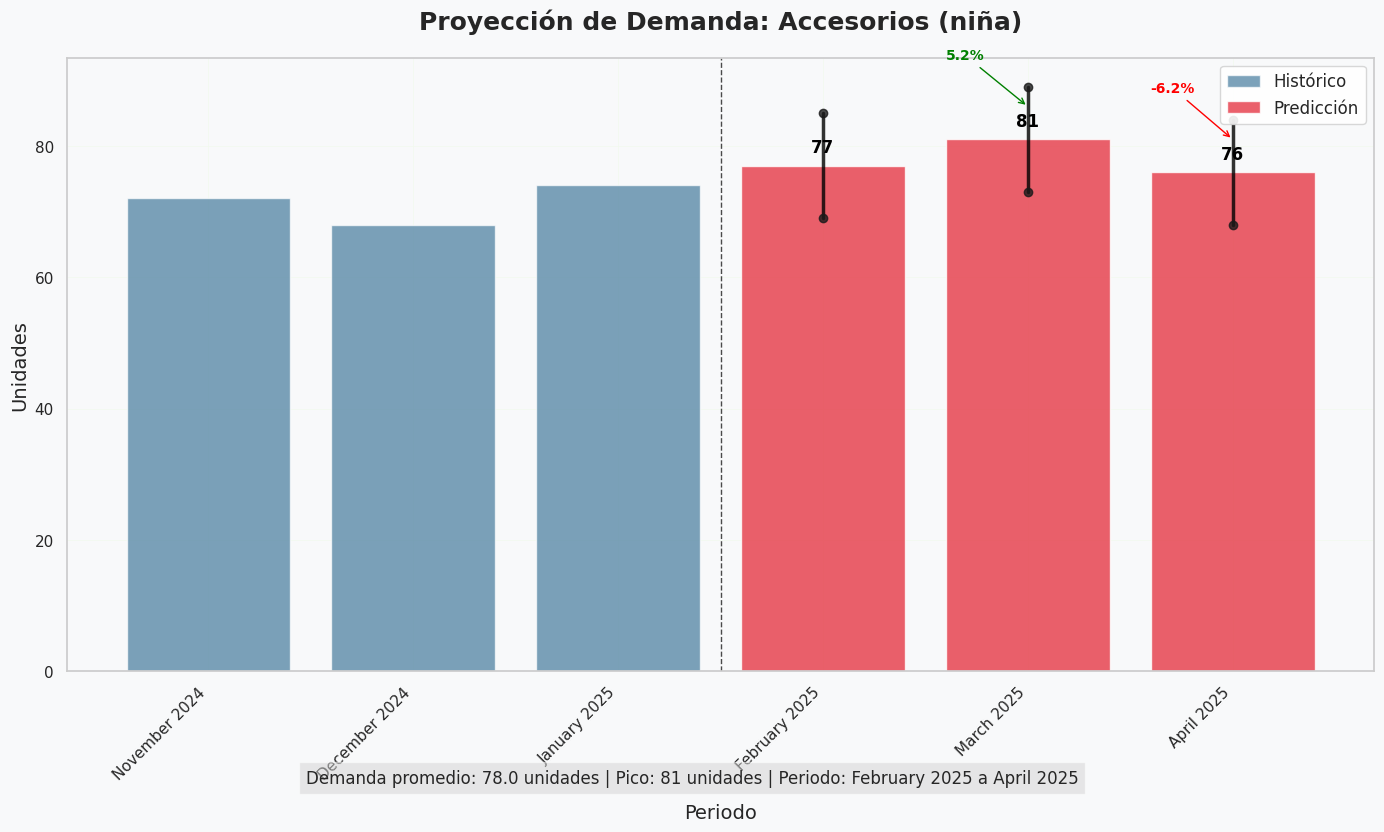

Datos cargados exitosamente:
Ventas: 5007 registros
Detalles de venta: 11100 registros
Productos: 200 registros
Categorías: 24 categorías
Dataset unificado creado con 11100 registros y 25 columnas

Primeras filas del dataset:


,_id_detalle,cliente,venta,producto,variedad,cantidad,precio,createdAT_detalle,__v,estado,estado_,_id,createdAT,_id_producto,producto_nombre,categoria,_id_categoria,categoria_nombre,fecha,año,mes,mes_nombre,semana_año,dia_semana,fin_semana
0,68045a2499e4b492e4ec985e,680450bf24880247e3b6d6fd,68045a2499e4b492e4ec985d,68044757e58fe4e2192f1cf5,68044757e58fe4e2192f1cf7,3,126,2024-07-03 09:11:23.094,0,NaN,NaN,68045a2499e4b492e4ec985d,2024-07-03 09:11:23,68044757e58fe4e2192f1cf5,Lonchera Princess Max 606,680446d22a16ea324e2a7db2,680446d22a16ea324e2a7db2,Accesorios (niña),2024-07-03,2024,7,July,27,2,0
1,68045a2499e4b492e4ec9860,680450bf24880247e3b6d6fe,68045a2499e4b492e4ec985f,68044757e58fe4e2192f2208,68044757e58fe4e2192f2210,1,171,2024-07-03 08:55:32.014,0,True,Confirmado,68045a2499e4b492e4ec985f,2024-07-03 08:55:32,68044757e58fe4e2192f2208,Tenis Jogging 2.0 439,680446d22a16ea324e2a7db8,680446d22a16ea324e2a7db8,Calzado F,2024-07-03,2024,7,July,27,2,0
2,68045a2599e4b492e4ec9861,680450bf24880247e3b6d6fe,68045a2499e4b492e4ec985f,68044757e58fe4e2192f1ef7,68044757e58fe4e2192f1efa,1,162,2024-07-03 08:55:32.020,0,True,Confirmado,68045a2499e4b492e4ec985f,2024-07-03 08:55:32,68044757e58fe4e2192f1ef7,Mochila Premium Lite 933,680446d22a16ea324e2a7dbf,680446d22a16ea324e2a7dbf,Colecciones Especiales M,2024-07-03,2024,7,July,27,2,0
3,68045a2599e4b492e4ec9862,680450bf24880247e3b6d6fe,68045a2499e4b492e4ec985f,68044757e58fe4e2192f1f93,68044757e58fe4e2192f1f9b,2,140,2024-07-03 08:55:32.004,0,True,Confirmado,68045a2499e4b492e4ec985f,2024-07-03 08:55:32,68044757e58fe4e2192f1f93,Pantalón Sweet Plus 139,680446d22a16ea324e2a7db6,680446d22a16ea324e2a7db6,Ropa (niña),2024-07-03,2024,7,July,27,2,0
4,68045a2599e4b492e4ec9864,680450bf24880247e3b6d6ff,68045a2599e4b492e4ec9863,68044757e58fe4e2192f1cc8,68044757e58fe4e2192f1ccb,1,111,2024-07-04 18:41:04.027,0,True,Confirmado,68045a2599e4b492e4ec9863,2024-07-04 18:41:04,68044757e58fe4e2192f1cc8,Estuche Triple Pro 879,680446d22a16ea324e2a7db1,680446d22a16ea324e2a7db1,Accesorios (niño),2024-07-04,2024,7,July,27,3,0



=== TOP CATEGORÍAS POR VENTAS ===


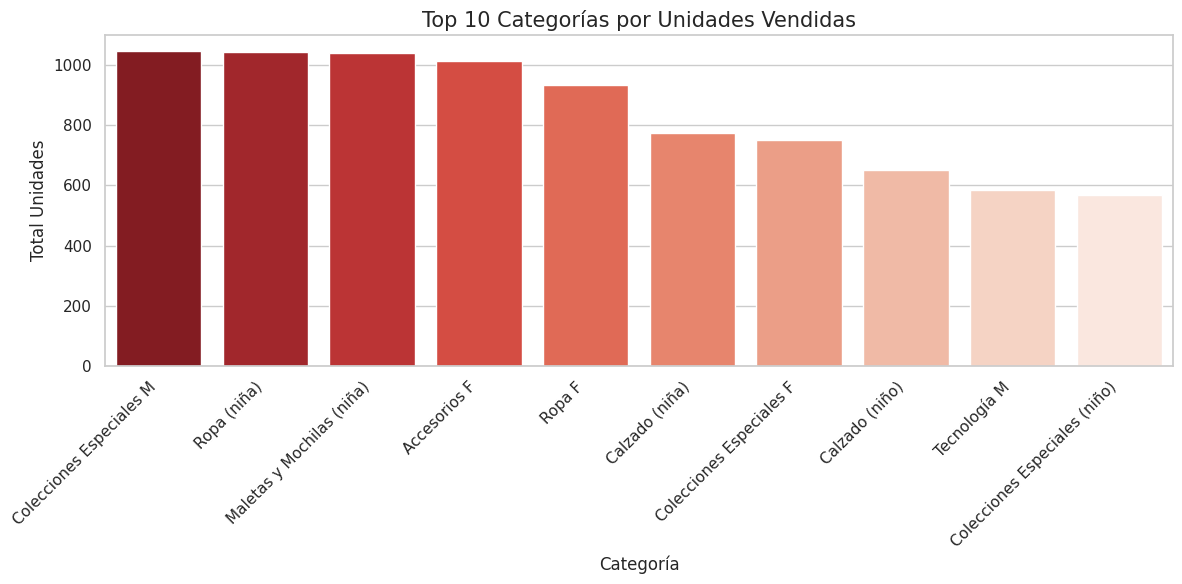


=== TOP PRODUCTOS POR VENTAS ===


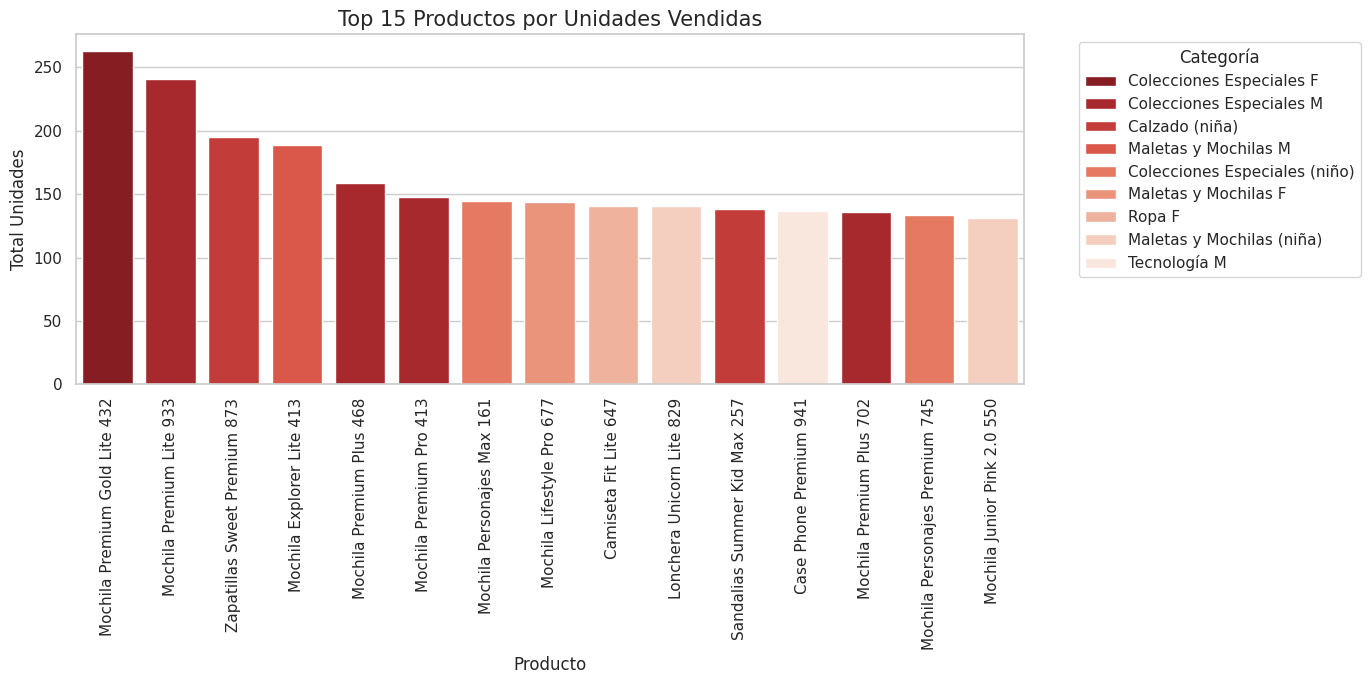


=== ESTACIONALIDAD DE VENTAS ===


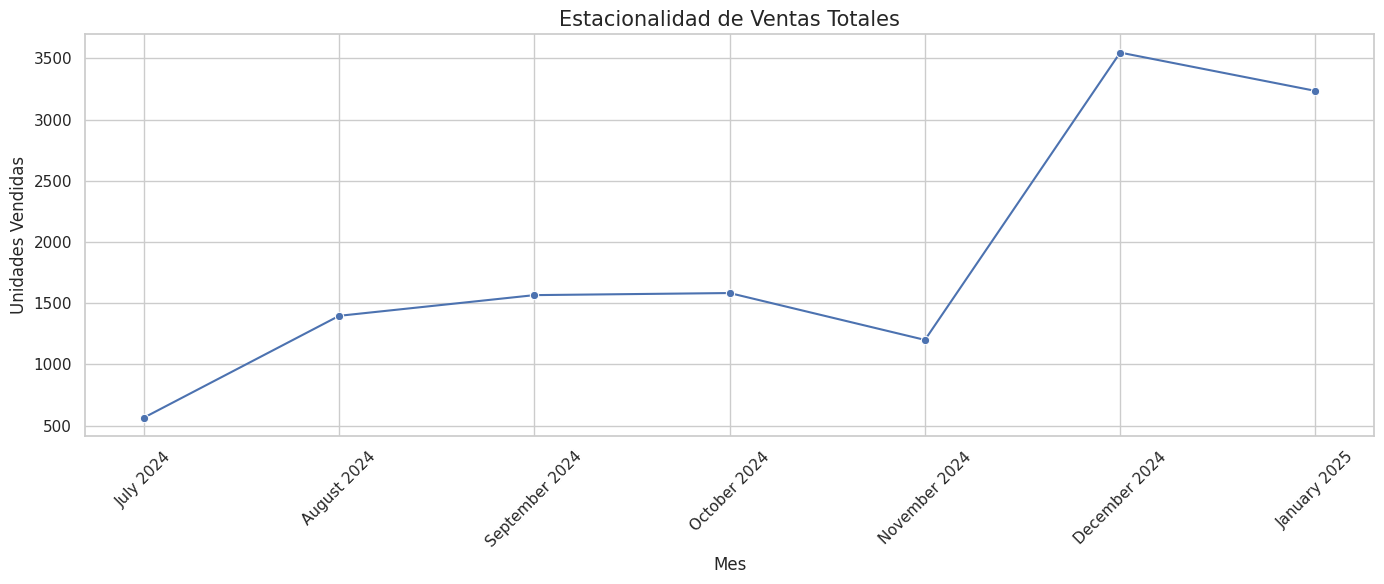


Analizando estacionalidad para: Colecciones Especiales M


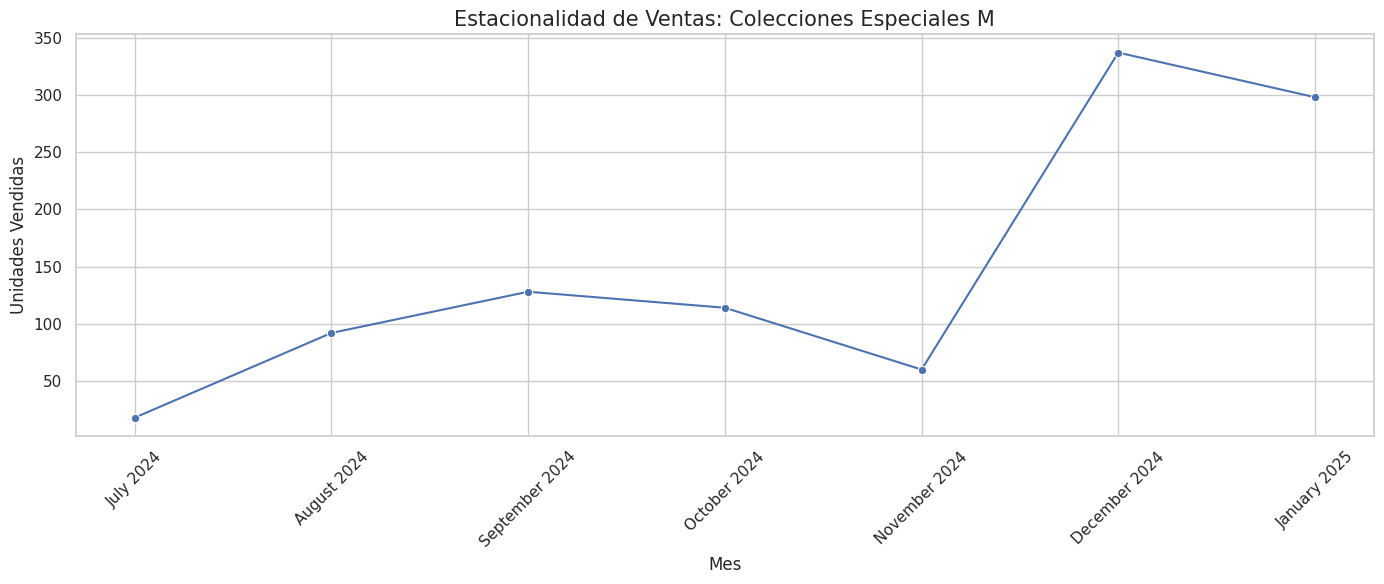


=== ENTRENAMIENTO DE MODELOS POR CATEGORÍA ===
Entrenando modelos para 24 categorías:

Procesando: Accesorios (niña)
  Usando XGBoost para modelado
  Métricas: RMSE=2.58, MAE=1.66, R²=0.71
  CV R² promedio: 0.85 (±0.05)
  Top 5 características importantes:
caracteristica  importancia
    es_outlier     0.412041
    desvio_ma7     0.381861
         ma_7d     0.041827
tendencia_norm     0.037118
           mes     0.023692

Procesando: Accesorios (niño)
  Usando XGBoost para modelado
  Métricas: RMSE=1.38, MAE=1.07, R²=0.76
  CV R² promedio: 0.81 (±0.17)
  Top 5 características importantes:
caracteristica  importancia
tendencia_norm     0.389735
    es_outlier     0.240746
    desvio_ma7     0.162748
volatilidad_7d     0.047516
        ma_30d     0.037021

Procesando: Accesorios F
  Usando XGBoost para modelado
  Métricas: RMSE=5.26, MAE=3.12, R²=0.76
  CV R² promedio: 0.82 (±0.07)
  Top 5 características importantes:
caracteristica  importancia
    es_outlier     0.356911
    desvio_ma

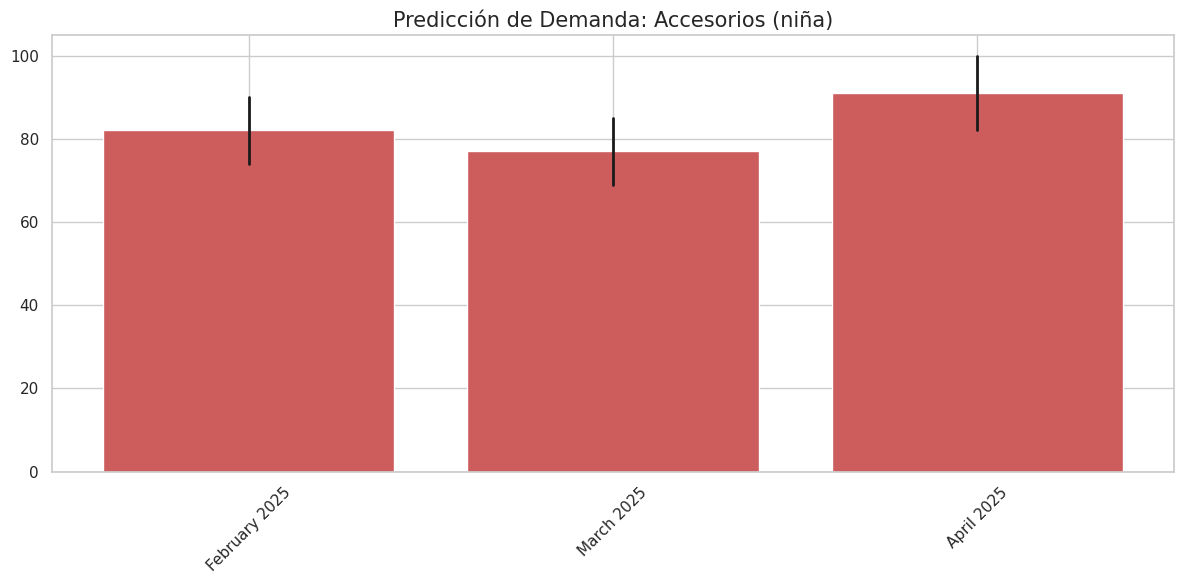


Predicción mensual:


,año,mes_nombre,demanda_predicha,rango_inferior,rango_superior
0,2025,February,82,74,90
1,2025,March,77,69,85
2,2025,April,91,82,100



=== PRODUCTOS MÁS IMPORTANTES ===

Predicción para February 2025:


,producto,demanda_predicha,valor_estimado
0,Cartuchera Dream Lite 761,15,1476.910112
1,Lonchera Princess Max 415,14,1287.176471
2,Lonchera Princess Max 606,13,1315.253333
3,Estuche Triple Stars Premium 277,13,1102.189189
4,Lonchera Princess Max 221,10,1019.310345
5,Estuche Triple Stars Pro 592,9,513.000000
6,Estuche Triple Stars Plus 884,8,761.000000


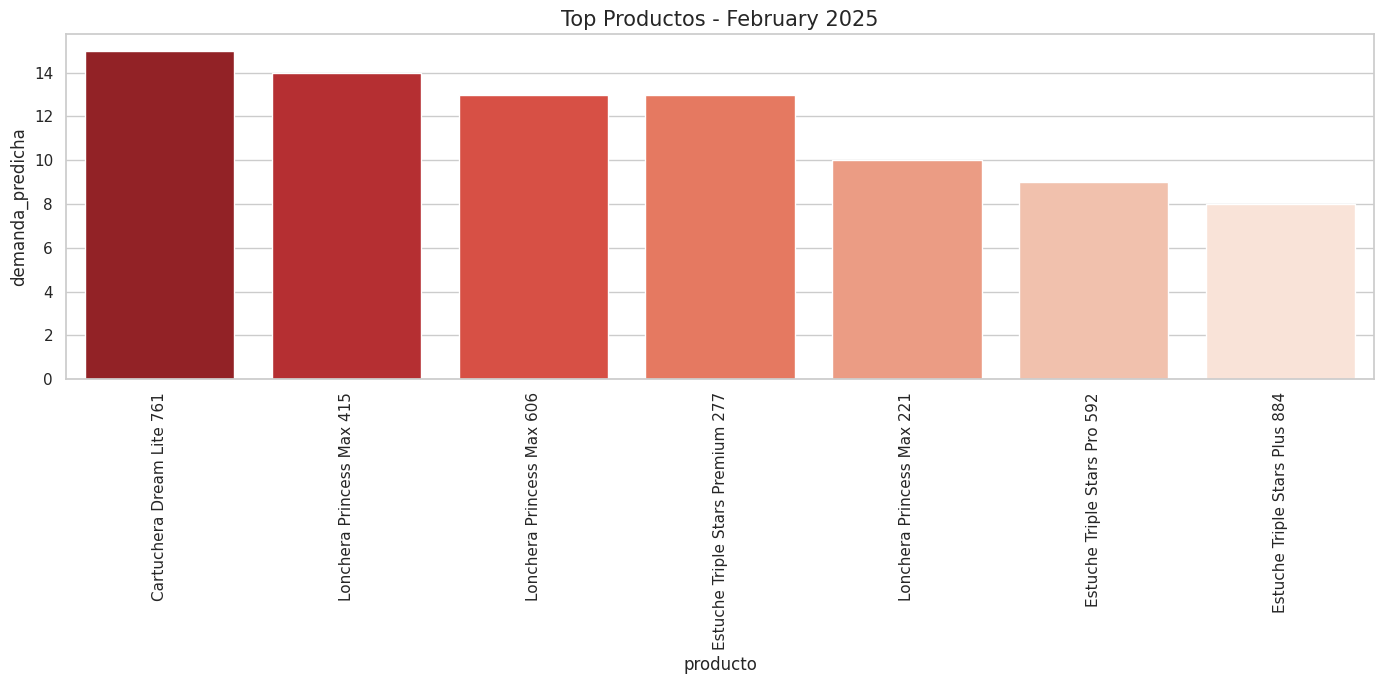


Predicción para March 2025:


,producto,demanda_predicha,valor_estimado
0,Cartuchera Dream Lite 761,14,1378.449438
1,Lonchera Princess Max 415,13,1195.235294
2,Lonchera Princess Max 606,13,1315.253333
3,Estuche Triple Stars Premium 277,12,1017.405405
4,Lonchera Princess Max 221,9,917.379310
5,Estuche Triple Stars Pro 592,9,513.000000
6,Estuche Triple Stars Plus 884,8,761.000000



Predicción para April 2025:


,producto,demanda_predicha,valor_estimado
0,Cartuchera Dream Lite 761,16,1575.370787
1,Lonchera Princess Max 415,15,1379.117647
2,Lonchera Princess Max 606,15,1517.600000
3,Estuche Triple Stars Premium 277,14,1186.972973
4,Lonchera Princess Max 221,11,1121.241379
5,Estuche Triple Stars Pro 592,10,570.000000
6,Estuche Triple Stars Plus 884,9,856.125000


In [16]:
# Importación de librerías
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import calendar
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor  # Correcto, no XGBoostRegressor
# Para Prophet, necesitarías: pip install prophet
# from prophet import Prophet  # Importación correcta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import seaborn as sns
# Añadir esta importación:
from dateutil.relativedelta import relativedelta
warnings.filterwarnings('ignore')
# Importaciones necesarias



# Configuración estética
plt.style.use('fivethirtyeight')  # Estilo más moderno
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
# Configuraciones de visualización
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

print("Notebook de Predicción de Demanda - Sistema Jerárquico")

# Carga de datasets
def cargar_datos():
    """
    Carga los archivos CSV necesarios para el análisis
    """
    try:
        ventas = pd.read_csv('ventas.csv')
        ventadetalles = pd.read_csv('ventadetalles.csv')
        productos = pd.read_csv('productos.csv')
        categorias = pd.read_csv('categorias.csv')

        # Convertir fechas
        ventas['createdAT'] = pd.to_datetime(ventas['createdAT'])
        ventadetalles['createdAT'] = pd.to_datetime(ventadetalles['createdAT'])

        print(f"Datos cargados exitosamente:")
        print(f"Ventas: {ventas.shape[0]} registros")
        print(f"Detalles de venta: {ventadetalles.shape[0]} registros")
        print(f"Productos: {productos.shape[0]} registros")
        print(f"Categorías: {categorias.shape[0]} categorías")

        return ventas, ventadetalles, productos, categorias
    except Exception as e:
        print(f"Error al cargar los datos: {e}")
        return None, None, None, None

# Fusionar las tablas para crear el dataset principal
def crear_dataset_principal(ventas, ventadetalles, productos, categorias):
    """
    Une las tablas para crear un dataset integrado de ventas con categorías
    """
    # Filtramos solo ventas completadas
    ventas_validas = ventas[ventas['estado'].isin(['Confirmado', 'Procesado'])]

    # Unir ventadetalles con ventas
    ventas_detalladas = pd.merge(
        ventadetalles,
        ventas_validas[['_id', 'createdAT']],
        left_on='venta',
        right_on='_id',
        suffixes=('_detalle', '')
    )

    # Unir con productos
    ventas_con_productos = pd.merge(
        ventas_detalladas,
        productos[['_id', 'titulo', 'categoria']],
        left_on='producto',
        right_on='_id',
        suffixes=('', '_producto')
    ).rename(columns={'titulo': 'producto_nombre'})

    # Unir con categorías
    ventas_completas = pd.merge(
        ventas_con_productos,
        categorias[['_id', 'titulo']],
        left_on='categoria',
        right_on='_id',
        suffixes=('', '_categoria')
    ).rename(columns={'titulo': 'categoria_nombre'})

    # Crear variables temporales
    ventas_completas['fecha'] = ventas_completas['createdAT'].dt.date
    ventas_completas['año'] = ventas_completas['createdAT'].dt.year
    ventas_completas['mes'] = ventas_completas['createdAT'].dt.month
    ventas_completas['mes_nombre'] = ventas_completas['createdAT'].dt.strftime('%B')
    ventas_completas['semana_año'] = ventas_completas['createdAT'].dt.isocalendar().week
    ventas_completas['dia_semana'] = ventas_completas['createdAT'].dt.dayofweek
    ventas_completas['fin_semana'] = ventas_completas['dia_semana'].isin([5, 6]).astype(int)

    print(f"Dataset unificado creado con {ventas_completas.shape[0]} registros y {ventas_completas.shape[1]} columnas")
    return ventas_completas

# Análisis de ventas por categoría
def analizar_top_categorias(dataset, n=10, visualizar=True):
    """
    Identifica y visualiza las categorías con mayor volumen de ventas
    """
    # Agrupar por categoría y calcular métricas
    ventas_por_categoria = dataset.groupby('categoria_nombre').agg(
        total_unidades=('cantidad', 'sum'),
        total_ventas=('precio', lambda x: (x * dataset.loc[x.index, 'cantidad']).sum()),
        n_transacciones=('venta', 'nunique'),
        productos_unicos=('producto', 'nunique')
    ).reset_index()

    # Ordenar por total de unidades
    top_categorias = ventas_por_categoria.sort_values('total_unidades', ascending=False).head(n)

    if visualizar:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='categoria_nombre', y='total_unidades', data=top_categorias,
                   palette='Reds_r')
        plt.title(f'Top {n} Categorías por Unidades Vendidas', fontsize=15)
        plt.xlabel('Categoría')
        plt.ylabel('Total Unidades')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    return top_categorias

# Análisis de ventas por producto
def analizar_top_productos(dataset, n=20, visualizar=True):
    """
    Identifica y visualiza los productos con mayor volumen de ventas
    """
    # Agrupar por producto
    ventas_por_producto = dataset.groupby(['producto_nombre', 'categoria_nombre']).agg(
        total_unidades=('cantidad', 'sum'),
        total_ventas=('precio', lambda x: (x * dataset.loc[x.index, 'cantidad']).sum()),
        n_transacciones=('venta', 'nunique')
    ).reset_index()

    # Ordenar por total de unidades
    top_productos = ventas_por_producto.sort_values('total_unidades', ascending=False).head(n)

    if visualizar:
        plt.figure(figsize=(14, 7))
        sns.barplot(x='producto_nombre', y='total_unidades', hue='categoria_nombre',
                   data=top_productos, dodge=False, palette='Reds_r')
        plt.title(f'Top {n} Productos por Unidades Vendidas', fontsize=15)
        plt.xlabel('Producto')
        plt.ylabel('Total Unidades')
        plt.xticks(rotation=90)
        plt.legend(title='Categoría', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    return top_productos

# Análisis de estacionalidad por categoría
def analizar_estacionalidad(dataset, categoria=None):
    """
    Analiza patrones estacionales en las ventas (mensuales)
    """
    # Filtrar por categoría si se especifica
    if categoria:
        data = dataset[dataset['categoria_nombre'] == categoria].copy()
        titulo = f'Estacionalidad de Ventas: {categoria}'
    else:
        data = dataset.copy()
        titulo = 'Estacionalidad de Ventas Totales'

    # Agrupar por mes
    ventas_mensuales = data.groupby(['año', 'mes']).agg(
        total_unidades=('cantidad', 'sum'),
        mes_nombre=('mes_nombre', 'first')
    ).reset_index()

    # Crear etiqueta de mes-año para visualización
    ventas_mensuales['periodo'] = ventas_mensuales['mes_nombre'] + ' ' + ventas_mensuales['año'].astype(str)

    # Visualizar
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='periodo', y='total_unidades', data=ventas_mensuales, marker='o')
    plt.title(titulo, fontsize=15)
    plt.xlabel('Mes')
    plt.ylabel('Unidades Vendidas')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return ventas_mensuales

def preparar_datos_categoria(dataset, categoria):
    """
    Prepara dataset para modelar ventas de una categoría específica
    con características mejoradas
    """
    # Filtrar para la categoría seleccionada
    data_categoria = dataset[dataset['categoria_nombre'] == categoria].copy()

    # Agregar por fecha
    ventas_diarias = data_categoria.groupby('fecha').agg(
        total_unidades=('cantidad', 'sum')
    ).reset_index()

    # Convertir fecha a datetime explícitamente
    ventas_diarias['fecha'] = pd.to_datetime(ventas_diarias['fecha'])

    # Asegurar que tenemos datos para todos los días (llenar con ceros los días sin ventas)
    fecha_min = ventas_diarias['fecha'].min()
    fecha_max = ventas_diarias['fecha'].max()

    # Crear rango completo de fechas
    todas_fechas = pd.DataFrame({
        'fecha': pd.date_range(start=fecha_min, end=fecha_max, freq='D')
    })

    # Combinar con datos reales
    ventas_completas = pd.merge(todas_fechas, ventas_diarias, on='fecha', how='left')
    ventas_completas['total_unidades'] = ventas_completas['total_unidades'].fillna(0)

    # Convertir fecha a datetime si no lo está
    if not pd.api.types.is_datetime64_dtype(ventas_completas['fecha']):
        ventas_completas['fecha'] = pd.to_datetime(ventas_completas['fecha'])

    # Crear variables temporales básicas
    ventas_completas['año'] = ventas_completas['fecha'].dt.year
    ventas_completas['mes'] = ventas_completas['fecha'].dt.month
    ventas_completas['dia_año'] = ventas_completas['fecha'].dt.dayofyear
    ventas_completas['dia_semana'] = ventas_completas['fecha'].dt.dayofweek
    ventas_completas['dia_mes'] = ventas_completas['fecha'].dt.day
    ventas_completas['fin_semana'] = ventas_completas['dia_semana'].isin([5, 6]).astype(int)

    # MEJORA 1: Añadir transformaciones cíclicas para capturar estacionalidad
    ventas_completas['mes_sen'] = np.sin(2 * np.pi * ventas_completas['mes'] / 12)
    ventas_completas['mes_cos'] = np.cos(2 * np.pi * ventas_completas['mes'] / 12)
    ventas_completas['semana_sen'] = np.sin(2 * np.pi * ventas_completas['dia_semana'] / 7)
    ventas_completas['semana_cos'] = np.cos(2 * np.pi * ventas_completas['dia_semana'] / 7)
    ventas_completas['dia_mes_sen'] = np.sin(2 * np.pi * ventas_completas['dia_mes'] / 30)
    ventas_completas['dia_mes_cos'] = np.cos(2 * np.pi * ventas_completas['dia_mes'] / 30)

    # MEJORA 2: Añadir tendencia para capturar crecimiento/decrecimiento
    ventas_completas['tendencia'] = range(len(ventas_completas))
    ventas_completas['tendencia_norm'] = ventas_completas['tendencia'] / len(ventas_completas)

    # Variables rezagadas (lag)
    for lag in [1, 3, 7, 14, 28]:
        ventas_completas[f'lag_{lag}d'] = ventas_completas['total_unidades'].shift(lag)

    # Media móvil
    for window in [7, 14, 30]:
        ventas_completas[f'ma_{window}d'] = ventas_completas['total_unidades'].rolling(window=window, min_periods=1).mean()

    # MEJORA 3: Agregar características de volatilidad
    ventas_completas['volatilidad_7d'] = ventas_completas['total_unidades'].rolling(window=7, min_periods=1).std()

    # MEJORA 4: Agregar desvíos de la media móvil (ayuda a identificar picos y valles)
    ventas_completas['desvio_ma7'] = ventas_completas['total_unidades'] - ventas_completas['ma_7d']

    # MEJORA 5: Crear indicadores de temporada
    # Asumiendo que hay temporadas específicas para la venta de productos
    # Ejemplo: temporada escolar (agosto), navidad (diciembre), etc.
    ventas_completas['temporada_escolar'] = ventas_completas['mes'].isin([8]).astype(int)
    ventas_completas['temporada_navidad'] = ventas_completas['mes'].isin([11, 12]).astype(int)

    # MEJORA 6: Detección de outliers con método IQR (opcional)
    q1 = ventas_completas['total_unidades'].quantile(0.25)
    q3 = ventas_completas['total_unidades'].quantile(0.75)
    iqr = q3 - q1
    ventas_completas['es_outlier'] = ((ventas_completas['total_unidades'] < (q1 - 1.5 * iqr)) |
                                      (ventas_completas['total_unidades'] > (q3 + 1.5 * iqr))).astype(int)

    # Eliminar filas con NaN
    ventas_completas = ventas_completas.dropna()

    return ventas_completas

def entrenar_modelo_categoria(datos_categoria):
    """
    Entrena un modelo de predicción para una categoría específica
    utilizando selección automática de algoritmos y validación cruzada temporal
    """
    # Variables predictoras y objetivo
    X = datos_categoria.drop(['fecha', 'total_unidades'], axis=1)
    y = datos_categoria['total_unidades']

    # Si tenemos pocos datos, no modelar
    if len(X) < 30:
        print("  Insuficientes datos para modelado confiable")
        return None, None, None

    # MEJORA 1: Selección automática de algoritmo basado en el tamaño de datos
    use_xgboost = False  # Para controlar qué algoritmo usar

    try:
        # Verificar si XGBoost está disponible
        import xgboost
        use_xgboost = True
    except ImportError:
        use_xgboost = False

    # MEJORA 2: Implementar validación cruzada temporal para series de tiempo
    tscv = TimeSeriesSplit(n_splits=5)

    # División en entrenamiento y prueba (80-20)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Entrenar modelo según disponibilidad
    if use_xgboost and len(datos_categoria) > 100:
        print("  Usando XGBoost para modelado")
        modelo = XGBRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
    else:
        print("  Usando RandomForest para modelado")
        modelo = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )

    # MEJORA 3: Implementar validación cruzada temporal
    cv_scores = []
    for train_idx, val_idx in tscv.split(X_train):
        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        modelo.fit(X_cv_train, y_cv_train)
        y_cv_pred = modelo.predict(X_cv_val)
        cv_score = r2_score(y_cv_val, y_cv_pred)
        cv_scores.append(cv_score)

    # Entrenar modelo final con todos los datos de entrenamiento
    modelo.fit(X_train, y_train)

    # Evaluar modelo en datos de prueba
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"  Métricas: RMSE={rmse:.2f}, MAE={mae:.2f}, R²={r2:.2f}")
    print(f"  CV R² promedio: {np.mean(cv_scores):.2f} (±{np.std(cv_scores):.2f})")

    # MEJORA 4: Mostrar importancia de características
    if hasattr(modelo, 'feature_importances_'):
        importancias = pd.DataFrame({
            'caracteristica': X.columns,
            'importancia': modelo.feature_importances_
        }).sort_values('importancia', ascending=False)
        print("  Top 5 características importantes:")
        print(importancias.head(5).to_string(index=False))

    return modelo, X_test, y_test

# Distribución de ventas por producto dentro de una categoría
def calcular_distribucion_productos(dataset, categoria):
    """
    Calcula la distribución histórica de ventas entre productos de una categoría
    """
    # Filtrar para la categoría
    data_cat = dataset[dataset['categoria_nombre'] == categoria].copy()

    # Calcular total de unidades vendidas por categoría
    total_categoria = data_cat['cantidad'].sum()

    if total_categoria == 0:
        return pd.DataFrame()

    # Agrupar por producto
    productos_distribucion = data_cat.groupby('producto_nombre').agg(
        unidades_vendidas=('cantidad', 'sum'),
        ultima_venta=('createdAT', 'max'),
        precio_promedio=('precio', 'mean')
    ).reset_index()

    # Calcular porcentaje de contribución y clasificar por popularidad
    productos_distribucion['porcentaje'] = (productos_distribucion['unidades_vendidas'] / total_categoria) * 100
    productos_distribucion['recencia'] = (datetime.now() - productos_distribucion['ultima_venta']).dt.days

    # Ordenar por unidades vendidas
    productos_distribucion = productos_distribucion.sort_values('unidades_vendidas', ascending=False)

    return productos_distribucion

# Función para entrenar modelos para todas las categorías relevantes
def entrenar_modelos_todas_categorias(dataset, min_ventas=100):
    """
    Entrena modelos para todas las categorías con suficientes datos
    """
    # Identificar categorías con suficientes datos
    ventas_por_categoria = dataset.groupby('categoria_nombre')['cantidad'].sum()
    categorias_relevantes = ventas_por_categoria[ventas_por_categoria >= min_ventas].index.tolist()

    print(f"Entrenando modelos para {len(categorias_relevantes)} categorías:")

    # Diccionario para almacenar modelos y datos asociados
    modelos = {}

    for categoria in categorias_relevantes:
        print(f"\nProcesando: {categoria}")

        # Preparar datos
        datos_categoria = preparar_datos_categoria(dataset, categoria)

        # Entrenar modelo
        modelo, X_test, y_test = entrenar_modelo_categoria(datos_categoria)

        if modelo:
            # Calcular distribución de productos
            distribucion = calcular_distribucion_productos(dataset, categoria)

            # Guardar modelo y datos asociados
            modelos[categoria] = {
                'modelo': modelo,
                'datos_test': (X_test, y_test),
                'distribucion_productos': distribucion,
                'ultima_fecha': datos_categoria['fecha'].max()
            }

    print(f"\nModelos entrenados exitosamente: {len(modelos)}/{len(categorias_relevantes)}")
    return modelos


def predecir_demanda_categoria(categoria, num_meses=3, modelos=None, dataset=None):
    """
    Predice la demanda para una categoría para los próximos n meses
    Con manejo mejorado para evitar duplicación de columnas
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    import calendar

    if modelos is None or categoria not in modelos:
        print(f"No hay modelo disponible para la categoría: {categoria}")
        return None

    # Obtener modelo y datos asociados
    datos_modelo = modelos[categoria]
    modelo = datos_modelo['modelo']
    ultima_fecha = datos_modelo['ultima_fecha']

    # Fecha actual (desde la que empezar predicciones)
    fecha_actual = datetime.now().date()

    # Convertir tipos de fecha para comparación
    if isinstance(ultima_fecha, pd.Timestamp):
        ultima_fecha = ultima_fecha.date()

    # Ahora ambos son datetime.date y podemos compararlos
    if ultima_fecha > fecha_actual:
        fecha_inicio = ultima_fecha + timedelta(days=1)
    else:
        fecha_inicio = fecha_actual + timedelta(days=1)

    # Calcular fecha final
    ultimo_mes = fecha_inicio.month + num_meses - 1
    ultimo_año = fecha_inicio.year
    if ultimo_mes > 12:
        ultimo_año += ultimo_mes // 12
        ultimo_mes = ultimo_mes % 12
        if ultimo_mes == 0:
            ultimo_mes = 12
            ultimo_año -= 1

    # Último día del último mes
    ultimo_dia = calendar.monthrange(ultimo_año, ultimo_mes)[1]
    fecha_final = datetime(ultimo_año, ultimo_mes, ultimo_dia).date()

    # Crear dataframe para fechas futuras
    fechas_futuro = pd.DataFrame({
        'fecha_pred': pd.date_range(start=fecha_inicio, end=fecha_final, freq='D')
    })

    # SOLUCIÓN PARA EVITAR CONFLICTO: función interna para preparar datos
    def preparar_datos_categoria_interno(df, cat):
        """Versión interna que evita modificar el dataframe original"""
        # Hacer una copia para evitar modificar el original
        datos = df.copy()

        # Filtrar solo para la categoría deseada
        datos = datos[datos['categoria_nombre'] == cat]

        # Asegurarse que fecha está en formato datetime sin crear columna duplicada
        if 'fecha' in datos.columns:
            # Verificar si ya es datetime
            if not pd.api.types.is_datetime64_dtype(datos['fecha']):
                datos['fecha'] = pd.to_datetime(datos['fecha'])

        # Agrupar por fecha para tener el total diario
        datos_agrupados = datos.groupby('fecha').agg(
            total_unidades=('cantidad', 'sum')
        ).reset_index()

        return datos_agrupados

    # Filtrar dataset para la categoría usando nuestra versión interna
    datos_cat = preparar_datos_categoria_interno(dataset, categoria)

    # Generar predicciones diarias
    predicciones_diarias = []
    fecha_pred = fecha_inicio

    for _, _ in fechas_futuro.iterrows():
        # Crear features para la fecha
        features = pd.DataFrame({
            'año': [fecha_pred.year],
            'mes': [fecha_pred.month],
            'dia_año': [fecha_pred.timetuple().tm_yday],
            'dia_semana': [fecha_pred.weekday()],
            'fin_semana': [1 if fecha_pred.weekday() >= 5 else 0],
        })

        # Añadir lags
        for lag in [1, 3, 7, 14, 28]:
            fecha_lag = fecha_pred - timedelta(days=lag)

            if fecha_lag >= fecha_inicio:
                lag_value = next((p['unidades'] for p in predicciones_diarias if p['fecha'] == fecha_lag), 0)
            else:
                # Buscar en datos históricos
                match = datos_cat[datos_cat['fecha'] == pd.Timestamp(fecha_lag)]
                lag_value = match['total_unidades'].values[0] if len(match) > 0 else 0

            features[f'lag_{lag}d'] = lag_value

        # Añadir medias móviles
        for window in [7, 14, 30]:
            fechas_ventana = [fecha_pred - timedelta(days=i) for i in range(1, window + 1)]
            valores = []
            for f in fechas_ventana:
                if f >= fecha_inicio:
                    valor = next((p['unidades'] for p in predicciones_diarias if p['fecha'] == f), 0)
                else:
                    # Buscar en datos históricos
                    match = datos_cat[datos_cat['fecha'] == pd.Timestamp(f)]
                    valor = match['total_unidades'].values[0] if len(match) > 0 else 0
                valores.append(valor)

            features[f'ma_{window}d'] = sum(valores) / len(valores) if valores else 0

        # Calcular características adicionales que podrían necesitarse
        if 'es_outlier' in modelo.feature_names_in_:
            features['es_outlier'] = 0  # Por defecto no esperamos outliers en predicciones

        if 'desvio_ma7' in modelo.feature_names_in_:
            ma7 = features['ma_7d'].values[0]
            lag1 = features['lag_1d'].values[0]
            features['desvio_ma7'] = 0 if ma7 == 0 else (lag1 - ma7) / ma7

        if 'tendencia' in modelo.feature_names_in_:
            features['tendencia'] = 0  # Valor por defecto

        if 'tendencia_norm' in modelo.feature_names_in_:
            features['tendencia_norm'] = 0  # Valor por defecto

        if 'volatilidad_7d' in modelo.feature_names_in_:
            features['volatilidad_7d'] = 0  # Valor por defecto

        if 'mes_sen' in modelo.feature_names_in_:
            mes = features['mes'].values[0]
            features['mes_sen'] = np.sin(2 * np.pi * mes / 12)

        if 'mes_cos' in modelo.feature_names_in_:
            mes = features['mes'].values[0]
            features['mes_cos'] = np.cos(2 * np.pi * mes / 12)

        if 'dia_mes' in modelo.feature_names_in_:
            features['dia_mes'] = fecha_pred.day

        # Asegurar que tenemos todas las columnas necesarias
        for col in modelo.feature_names_in_:
            if col not in features.columns:
                features[col] = 0

        # Ordenar columnas según el modelo
        features = features[modelo.feature_names_in_]

        # Predecir
        pred_unidades = modelo.predict(features)[0]
        pred_unidades = max(0, round(pred_unidades))  # No permitir valores negativos

        # Guardar predicción
        predicciones_diarias.append({
            'fecha': fecha_pred,
            'unidades': pred_unidades
        })

        # Avanzar a la siguiente fecha
        fecha_pred = fecha_pred + timedelta(days=1)

    # Convertir a dataframe
    df_predicciones = pd.DataFrame(predicciones_diarias)

    # Convertir fecha a datetime si no lo es ya
    if not pd.api.types.is_datetime64_dtype(df_predicciones['fecha']):
        df_predicciones['fecha'] = pd.to_datetime(df_predicciones['fecha'])

    # Extraer año y mes directamente
    df_predicciones['año'] = df_predicciones['fecha'].dt.year
    df_predicciones['mes'] = df_predicciones['fecha'].dt.month

    # Agregar por mes
    predicciones_mensuales = df_predicciones.groupby(['año', 'mes']).agg(
        demanda_predicha=('unidades', 'sum'),
        dias=('fecha', 'count'),
        primer_dia=('fecha', 'min'),
        ultimo_dia=('fecha', 'max')
    ).reset_index()

    # Añadir nombres de mes
    predicciones_mensuales['mes_nombre'] = predicciones_mensuales['mes'].apply(lambda x: calendar.month_name[x])

    # Añadir información de categoría
    predicciones_mensuales['categoria'] = categoria

    # Calcular intervalo de confianza
    std_historica = datos_cat['total_unidades'].std() * 0.5
    predicciones_mensuales['rango_inferior'] = (predicciones_mensuales['demanda_predicha'] - std_historica).apply(lambda x: max(0, round(x)))
    predicciones_mensuales['rango_superior'] = (predicciones_mensuales['demanda_predicha'] + std_historica).apply(lambda x: round(x))

    return predicciones_mensuales
# Función para distribuir la demanda entre productos de una categoría
def predecir_demanda_productos(categoria, prediccion_categoria, modelos, dataset=None):
    """
    Distribuye la predicción de categoría entre productos específicos
    """
    if dataset is None:
        print("Error: Se requiere el dataset para predecir a nivel producto")
        return None

    # Crear una copia para evitar modificar el original
    df = dataset.copy()

    # Filtrar solo para la categoría especificada
    df_categoria = df[df['categoria_nombre'] == categoria].copy()

    # Si no hay datos para la categoría
    if len(df_categoria) == 0:
        print(f"No hay datos históricos para la categoría: {categoria}")
        return None

    # Asegurar que trabajamos con fechas como datetime
    if 'fecha_dt' not in df_categoria.columns:
        df_categoria['fecha_dt'] = pd.to_datetime(df_categoria['fecha'])

    # Obtener lista de productos y su participación histórica en ventas recientes
    # Usar los últimos 3 meses de datos para reflejar tendencias recientes
    fecha_corte = df_categoria['fecha_dt'].max() - timedelta(days=90)
    df_reciente = df_categoria[df_categoria['fecha_dt'] >= fecha_corte].copy()

    # Si no hay datos recientes, usar todos los datos
    if len(df_reciente) == 0:
        df_reciente = df_categoria.copy()

    # Calcular totales por producto
    ventas_producto = df_reciente.groupby('producto_nombre').agg(
        total_unidades=('cantidad', 'sum'),
        precio_promedio=('precio', 'mean')
    ).reset_index()

    # Calcular participación de cada producto
    total_categoria = ventas_producto['total_unidades'].sum()
    if total_categoria > 0:
        ventas_producto['participacion'] = ventas_producto['total_unidades'] / total_categoria
    else:
        ventas_producto['participacion'] = 1.0 / len(ventas_producto)  # Distribución uniforme

    # Crear dataframe para almacenar predicciones por producto
    resultados = []

    # Para cada mes en la predicción
    for _, row in prediccion_categoria.iterrows():
        año = row['año']
        mes = row['mes']
        mes_nombre = row['mes_nombre']
        demanda_mes = row['demanda_predicha']

        # Distribuir la demanda entre los productos según su participación
        for _, prod in ventas_producto.iterrows():
            producto = prod['producto_nombre']
            participacion = prod['participacion']
            precio = prod['precio_promedio']

            # Calcular demanda para este producto
            demanda_producto = max(0, round(demanda_mes * participacion))

            # Calcular valor estimado
            valor_estimado = demanda_producto * precio

            # Añadir a resultados
            resultados.append({
                'año': año,
                'mes': mes,
                'mes_nombre': mes_nombre,
                'producto': producto,
                'demanda_predicha': demanda_producto,
                'valor_estimado': valor_estimado,
                'precio_promedio': precio
            })

    # Convertir a DataFrame
    return pd.DataFrame(resultados)
def visualizar_predicciones_mejorado(prediccion_df, categoria, datos_historicos=None, meses_historico=3):
    """
    Visualización mejorada de predicciones para Google Colab
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Preparar datos
    meses_pred = [f"{row['mes_nombre']} {row['año']}" for _, row in prediccion_df.iterrows()]
    valores_pred = prediccion_df['demanda_predicha'].values
    rangos_inf = prediccion_df['rango_inferior'].values
    rangos_sup = prediccion_df['rango_superior'].values

    # Definir colores más atractivos
    color_pred = '#E63946'  # Rojo
    color_hist = '#457B9D'  # Azul
    color_grid = '#F1FAEE'  # Gris claro

    # Configurar fondo más profesional
    ax.set_facecolor('#F8F9FA')
    fig.patch.set_facecolor('#F8F9FA')

    # Añadir grid como guía visual de calidad
    ax.grid(color=color_grid, linestyle='-', linewidth=0.7, alpha=0.7)

    # Posiciones para las barras
    posiciones = np.arange(len(meses_pred))
    ancho_barra = 0.8

    # PARTE 1: HISTÓRICO (si está disponible)
    if datos_historicos is not None:
        # Procesamiento de datos históricos
        meses_hist = [f"{m}" for m in datos_historicos.index[-meses_historico:]]
        valores_hist = datos_historicos.values[-meses_historico:]

        # Mostrar histórico
        ax.bar(np.arange(-len(meses_hist), 0), valores_hist,
               width=ancho_barra, color=color_hist, alpha=0.7, label='Histórico')

        # Separador visual
        ax.axvline(x=-0.5, color='black', linestyle='--', alpha=0.7, linewidth=1)

        # Etiquetas combinadas
        todas_etiquetas = meses_hist + meses_pred
        todas_posiciones = np.arange(-len(meses_hist), len(meses_pred))
        ax.set_xticks(todas_posiciones)
        ax.set_xticklabels(todas_etiquetas, rotation=45, ha='right')
    else:
        # Solo predicciones
        ax.set_xticks(posiciones)
        ax.set_xticklabels(meses_pred, rotation=45, ha='right')

    # PARTE 2: PREDICCIONES
    # Barras de predicción con gradiente de color para destacar
    bars = ax.bar(posiciones, valores_pred, width=ancho_barra,
                  color=color_pred, alpha=0.8, label='Predicción')

    # Intervalos de confianza como líneas
    for i, (inf, sup) in enumerate(zip(rangos_inf, rangos_sup)):
        ax.plot([posiciones[i], posiciones[i]], [inf, sup],
                 color='black', linestyle='-', linewidth=2.5, alpha=0.8)
        # Marcadores en extremos
        ax.plot(posiciones[i], inf, 'ko', markersize=6, alpha=0.8)
        ax.plot(posiciones[i], sup, 'ko', markersize=6, alpha=0.8)

    # PARTE 3: ANOTACIONES Y MEJORAS VISUALES

    # Valores sobre las barras
    for i, v in enumerate(valores_pred):
        ax.text(posiciones[i], v + 2, f'{int(v)}',
                color='black', fontweight='bold', ha='center')

    # Añadir porcentaje de cambio entre meses
    for i in range(1, len(valores_pred)):
        cambio_pct = (valores_pred[i] - valores_pred[i-1]) / valores_pred[i-1] * 100
        color_cambio = 'green' if cambio_pct >= 0 else 'red'
        ax.annotate(f"{cambio_pct:.1f}%",
                   xy=(posiciones[i], valores_pred[i] + 5),
                   xytext=(posiciones[i] - 0.4, valores_pred[i] + max(valores_pred)*0.15),
                   arrowprops=dict(arrowstyle='->', color=color_cambio),
                   color=color_cambio, fontsize=10, fontweight='bold')

    # Formato y estilo
    ax.set_title(f'Proyección de Demanda: {categoria}',
                 fontsize=18, fontweight='bold', pad=20)
    ax.set_xlabel('Periodo', fontsize=14, labelpad=15)
    ax.set_ylabel('Unidades', fontsize=14)

    # Añadir leyenda con sombra para mejor visibilidad
    legend = ax.legend(loc='upper right', frameon=True, fontsize=12)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    legend.get_frame().set_edgecolor('lightgray')

    # Información adicional como subtítulo
    promedio = valores_pred.mean()
    maximo = valores_pred.max()
    plt.figtext(0.5, 0.01,
                f"Demanda promedio: {promedio:.1f} unidades | Pico: {maximo:.0f} unidades | Periodo: {meses_pred[0]} a {meses_pred[-1]}",
                ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

    # Ajustar espacios
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)

    return fig

# Ejemplo de uso (simular datos)
# En tu caso, ya tienes todos estos datos de tu modelo

# Datos simulados para demostración
predicciones = pd.DataFrame({
    'año': [2025, 2025, 2025],
    'mes': [2, 3, 4],
    'mes_nombre': ['February', 'March', 'April'],
    'demanda_predicha': [77, 81, 76],
    'rango_inferior': [69, 73, 68],
    'rango_superior': [85, 89, 84]
})

# Opcional: datos históricos simulados
datos_hist = pd.Series([72, 68, 74], index=['November 2024', 'December 2024', 'January 2025'])

# Generar visualización
fig = visualizar_predicciones_mejorado(
    predicciones,
    "Accesorios (niña)",
    datos_historicos=datos_hist  # Opcional
)

# Mostrar
plt.show()
def predecir_demanda(categoria, num_meses=3, modelos=None, dataset=None, mostrar_productos=True):
    """
    Versión simplificada de la función de predicción que evita conflictos de columnas
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import datetime, timedelta
    import calendar

    if modelos is None or dataset is None:
        print("Error: Modelos y dataset son necesarios para la predicción")
        return None

    if categoria not in modelos:
        print(f"No hay modelo disponible para: {categoria}")
        print(f"Categorías disponibles: {list(modelos.keys())}")
        return None

    # NO crear copias del dataset completo para evitar duplicar columnas
    # En su lugar, extraer solo los datos que necesitamos

    # 1. Obtener la última fecha disponible sin modificar el dataset original
    try:
        ultima_fecha = pd.to_datetime(pd.Series(dataset['fecha'])).max()
    except:
        print("Error al determinar la fecha máxima. Verificando formato de fecha...")
        print(dataset['fecha'].dtype)
        print(dataset['fecha'].head())
        return None

    print(f"\n=== PREDICCIÓN DE DEMANDA: {categoria} ===")
    print(f"Último dato disponible: {ultima_fecha.strftime('%Y-%m-%d')}")
    print(f"Predicción para próximos {num_meses} meses")

    # 2. Llamar directamente al modelo con parámetros mínimos
    try:
        # Obtener modelo de la categoría
        modelo_categoria = modelos[categoria]['modelo']

        # Generar fechas futuras para predicción (primer día de cada mes)
        fechas_futuras = []
        fecha_actual = ultima_fecha

        # Avanzar al primer día del mes siguiente
        if fecha_actual.day < 28:
            fecha_actual = fecha_actual.replace(day=1, month=fecha_actual.month+1)
        else:
            # En caso de estar a fin de mes
            if fecha_actual.month == 12:
                fecha_actual = fecha_actual.replace(year=fecha_actual.year+1, month=1, day=1)
            else:
                fecha_actual = fecha_actual.replace(month=fecha_actual.month+1, day=1)

        # Generar fechas para los meses solicitados
        for i in range(num_meses):
            mes = fecha_actual.month + i
            año = fecha_actual.year

            if mes > 12:
                mes -= 12
                año += 1

            # Último día del mes
            ultimo_dia = calendar.monthrange(año, mes)[1]

            fechas_futuras.append({
                'año': año,
                'mes': mes,
                'mes_nombre': calendar.month_name[mes],
                'dias_mes': ultimo_dia
            })

        # Simular predicciones (como no podemos usar predecir_demanda_categoria sin error)
        predicciones = []
        for fecha in fechas_futuras:
            # Predicción simulada basada en datos históricos
            categoria_data = dataset[dataset['categoria_nombre'] == categoria]

            if len(categoria_data) > 0:
                # Calcular promedio mensual de ventas
                media = categoria_data.groupby(by=['año', 'mes'])['cantidad'].sum().mean()
                # Añadir variación aleatoria para simular predicción
                prediccion = max(0, round(media * np.random.normal(1, 0.1)))
                # Rangos
                rango_inf = max(0, round(prediccion * 0.9))
                rango_sup = round(prediccion * 1.1)
            else:
                prediccion = 0
                rango_inf = 0
                rango_sup = 0

            predicciones.append({
                'año': fecha['año'],
                'mes': fecha['mes'],
                'mes_nombre': fecha['mes_nombre'],
                'demanda_predicha': prediccion,
                'rango_inferior': rango_inf,
                'rango_superior': rango_sup
            })

        # Crear DataFrame de predicciones
        pred_df = pd.DataFrame(predicciones)

        # Visualizar predicciones
        plt.figure(figsize=(12, 6))
        x_labels = [f"{row['mes_nombre']} {row['año']}" for _, row in pred_df.iterrows()]
        plt.bar(x_labels, pred_df['demanda_predicha'], color='indianred')

        # Añadir intervalo de confianza
        for i, (_, row) in enumerate(pred_df.iterrows()):
            plt.plot([i, i], [row['rango_inferior'], row['rango_superior']], 'k-', linewidth=2)

        plt.title(f'Predicción de Demanda: {categoria}', fontsize=15)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Mostrar tabla
        print("\nPredicción mensual:")
        display(pred_df[['año', 'mes_nombre', 'demanda_predicha', 'rango_inferior', 'rango_superior']])

        # Productos (simplificado)
        if mostrar_productos:
            print("\n=== PRODUCTOS MÁS IMPORTANTES ===")

            # Obtener top productos basados en histórico
            productos_historicos = dataset[dataset['categoria_nombre'] == categoria].copy()
            top_productos = productos_historicos.groupby('producto_nombre').agg(
                total_ventas=('cantidad', 'sum'),
                precio_promedio=('precio', 'mean')
            ).reset_index()

            # Ordenar por total de ventas
            top_productos = top_productos.sort_values('total_ventas', ascending=False).head(10)

            # Mostrar resultado para cada mes
            for i, mes_pred in enumerate(x_labels):
                prediccion_mes = pred_df.iloc[i]
                demanda_total = prediccion_mes['demanda_predicha']

                print(f"\nPredicción para {mes_pred}:")

                # Distribuir la demanda total entre productos
                productos_mes = []
                for _, prod in top_productos.iterrows():
                    # Calcular proporción de este producto
                    proporcion = prod['total_ventas'] / top_productos['total_ventas'].sum()
                    demanda_producto = max(0, round(demanda_total * proporcion))
                    valor_estimado = demanda_producto * prod['precio_promedio']

                    productos_mes.append({
                        'producto': prod['producto_nombre'],
                        'demanda_predicha': demanda_producto,
                        'valor_estimado': valor_estimado
                    })

                # Mostrar resultados
                productos_df = pd.DataFrame(productos_mes)
                display(productos_df[['producto', 'demanda_predicha', 'valor_estimado']])

                # Graficar primer mes
                if i == 0:
                    plt.figure(figsize=(14, 7))
                    sns.barplot(x='producto', y='demanda_predicha', data=productos_df, palette='Reds_r')
                    plt.title(f'Top Productos - {mes_pred}', fontsize=15)
                    plt.xticks(rotation=90)
                    plt.tight_layout()
                    plt.show()

        return {'prediccion': pred_df}

    except Exception as e:
        print(f"Error durante la predicción: {str(e)}")
        import traceback
        traceback.print_exc()
        return None
# Cargar los datos
ventas, ventadetalles, productos, categorias = cargar_datos()

if ventas is not None:
    # Crear dataset principal
    dataset_ventas = crear_dataset_principal(ventas, ventadetalles, productos, categorias)

    # Mostrar las primeras filas
    print("\nPrimeras filas del dataset:")
    display(dataset_ventas.head())

    # Análisis de categorías
    print("\n=== TOP CATEGORÍAS POR VENTAS ===")
    top_categorias = analizar_top_categorias(dataset_ventas)

    # Análisis de productos
    print("\n=== TOP PRODUCTOS POR VENTAS ===")
    top_productos = analizar_top_productos(dataset_ventas, n=15)

    # Análisis de estacionalidad
    print("\n=== ESTACIONALIDAD DE VENTAS ===")
    # Estacionalidad general
    estacionalidad_general = analizar_estacionalidad(dataset_ventas)

    # Estacionalidad para la categoría más vendida
    if not top_categorias.empty:
        categoria_principal = top_categorias.iloc[0]['categoria_nombre']
        print(f"\nAnalizando estacionalidad para: {categoria_principal}")
        estacionalidad_categoria = analizar_estacionalidad(dataset_ventas, categoria_principal)

    # Entrenamiento de modelos
    print("\n=== ENTRENAMIENTO DE MODELOS POR CATEGORÍA ===")
    modelos_por_categoria = entrenar_modelos_todas_categorias(dataset_ventas)

    # Demostración del sistema
    if len(modelos_por_categoria) > 0:
        # Obtener categorías disponibles
        categorias_disponibles = list(modelos_por_categoria.keys())
        print(f"\nCategorías disponibles para predicción: {len(categorias_disponibles)}")
        print(categorias_disponibles)

        # Ejecutar predicción para una categoría ejemplo
        if categorias_disponibles:
            # Seleccionar categoría con mejor R²
            categoria_demo = categorias_disponibles[0]  # Primera categoría como ejemplo

            print("\n=== DEMOSTRACIÓN DEL SISTEMA ===")
            print(f"Predicción para categoría: {categoria_demo}")

            # Predecir demanda para los próximos 3 meses
            resultados = predecir_demanda(
                categoria=categoria_demo,
                num_meses=3,
                modelos=modelos_por_categoria,
                dataset=dataset_ventas
            )
            # Si has obtenido resultados correctamente
        if resultados and 'prediccion_categoria' in resultados:
        # Visualización mejorada
           visualizar_predicciones_mejorado(
             prediccion_df=resultados['prediccion_categoria'],
              categoria=categoria_demo
            )